In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
Y -> how many days until this product becomes active?

In [2]:
test = pd.read_csv("test_data.csv").set_index("sku").squeeze()
train = pd.read_parquet("./train/0.parquet")
train['date'] = pd.to_datetime(train['date'])
cats = ['item_domain_id', 'currency', 'listing_type', 'shipping_logistic_type', 'shipping_payment', 'site_id']
for cat in cats:
    train[cat] = train[cat].astype("category").cat.codes

In [3]:
train.loc[train["minutes_active"] == 0, "active"] = 0
train["active"] = train["active"].fillna(1)

In [4]:
act = train[train['active'] == 1][['sku', 'date']].sort_values("date")
act['active_date'] = act['date']
inact = train[train['active'] == 0][['sku', 'date', 'shipping_logistic_type', 'shipping_payment', 
                                                               'listing_type', 'currency', 'current_price', 'item_domain_id', 'site_id']].sort_values("date")
all_ = pd.merge_asof(inact, act, on=['date'], direction='forward', by=['sku']).dropna(subset=['active_date'])
all_['days_to_active'] = (all_['active_date'] - all_['date']) / np.timedelta64(1,'D')
all_['days_since_inactive'] = (all_['date'] - all_.groupby("sku")["date"].transform("min")) / np.timedelta64(1,'D')
y = all_['days_to_active'].copy()
all_.corr(method='spearman')

,sku,shipping_logistic_type,shipping_payment,listing_type,currency,current_price,item_domain_id,site_id,days_to_active,days_since_inactive
sku,1.000000,-0.000341,-0.002559,-0.000866,-0.002091,0.002278,-0.001439,0.000258,-0.001643,-0.001465
shipping_logistic_type,-0.000341,1.000000,0.074183,0.040746,0.050840,-0.089014,-0.031270,-0.019540,-0.009456,0.075642
shipping_payment,-0.002559,0.074183,1.000000,-0.074338,0.107770,-0.620856,-0.118603,-0.111873,-0.012127,-0.009789
listing_type,-0.000866,0.040746,-0.074338,1.000000,0.152052,-0.035744,0.072715,0.096491,0.029645,-0.007888
currency,-0.002091,0.050840,0.107770,0.152052,1.000000,-0.657856,-0.422581,-0.472765,-0.014007,-0.011959
current_price,0.002278,-0.089014,-0.620856,-0.035744,-0.657856,1.000000,0.267825,0.274570,0.014325,0.006590
item_domain_id,-0.001439,-0.031270,-0.118603,0.072715,-0.422581,0.267825,1.000000,0.893819,0.040363,0.022034
site_id,0.000258,-0.019540,-0.111873,0.096491,-0.472765,0.274570,0.893819,1.000000,0.038815,0.023721
days_to_active,-0.001643,-0.009456,-0.012127,0.029645,-0.014007,0.014325,0.040363,0.038815,1.000000,-0.118599
days_since_inactive,-0.001465,0.075642,-0.009789,-0.007888,-0.011959,0.006590,0.022034,0.023721,-0.118599,1.000000


In [5]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [6]:
Xtr = all_.loc[all_['date'] < "2021-03-01", ['days_since_inactive', 'current_price'] + cats]
Xval = all_.loc[all_['date'] >= "2021-03-01", ['days_since_inactive', 'current_price'] + cats]

ytr = y[all_['date'] < "2021-03-01"]
yval = y[all_['date'] >= "2021-03-01"]

#mdl = DecisionTreeRegressor(max_depth=3)
#mdl = RandomForestRegressor(n_estimators=100, max_depth=1, random_state=0, n_jobs=6)
mdl = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=0, n_jobs=6, tree_method='hist')
mdl.fit(Xtr, ytr)
p = mdl.predict(Xval)
np.sqrt(mean_squared_error(yval, p))

7.689729948430816

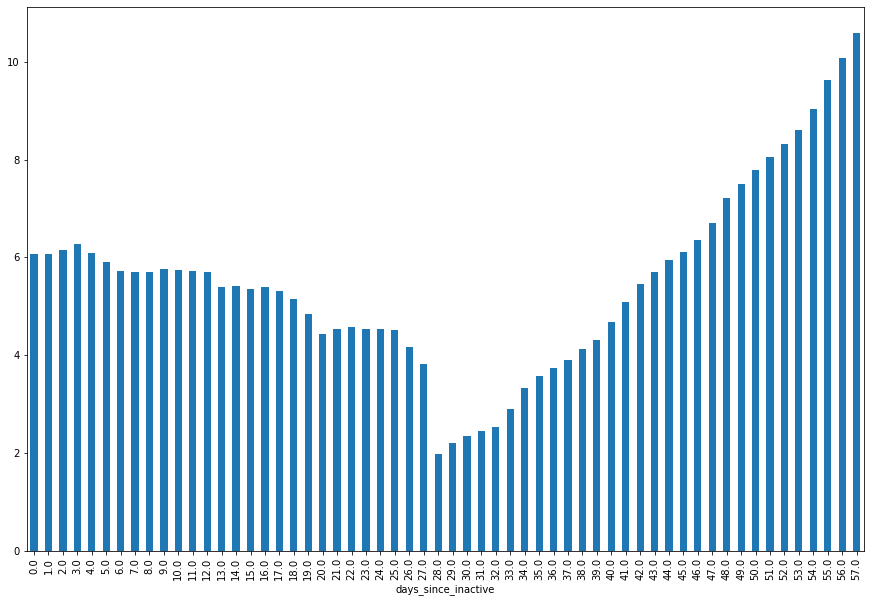

In [7]:
Xval['p'] = p
Xval['error'] = Xval['p'] - yval

Xval.groupby("days_since_inactive")['error'].mean().plot.bar(figsize=(15,10))

In [8]:
all_t = train[train['active'] == 0].copy()

all_t['days_since_inactive'] = (all_t['date'] - all_t.groupby("sku")["date"].transform("min")) / np.timedelta64(1,'D')
all_t = all_t.groupby("sku").last()
all_t = all_t[all_t['date'] == "2021-03-31"].copy()

In [9]:
all_t

,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,item_domain_id,site_id,active,days_since_inactive
sku,,,,,,,,,,,,
4,2021-03-31,0,118.00,3,1,2,0,0.0,5263,1,0.0,54.0
8,2021-03-31,0,58.49,2,1,2,1,0.0,6116,2,0.0,41.0
9,2021-03-31,0,199.00,2,1,2,0,0.0,7991,2,0.0,6.0
11,2021-03-31,0,109.90,3,0,2,0,0.0,3645,1,0.0,19.0
13,2021-03-31,0,474.05,2,1,2,0,0.0,5658,2,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
660897,2021-03-31,0,79.00,2,0,2,1,0.0,6201,2,0.0,58.0
660904,2021-03-31,0,98.90,3,1,2,1,0.0,3678,1,0.0,24.0
660907,2021-03-31,0,24.69,3,1,2,1,0.0,4703,1,0.0,56.0


In [10]:
X = all_.loc[:, ['days_since_inactive', 'current_price'] + cats]
Xt = all_t.loc[:, ['days_since_inactive', 'current_price'] + cats]

mdl = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=0, n_jobs=6, tree_method='hist')
mdl.fit(X, y)
p = mdl.predict(Xt)

In [11]:
p2 = pd.Series(p.round(), index=Xt.index).reindex(test.index).dropna().astype(int)

In [12]:
Xt.head()

,days_since_inactive,current_price,item_domain_id,currency,listing_type,shipping_logistic_type,shipping_payment,site_id
sku,,,,,,,,
4,54.0,118.00,5263,3,1,2,0,1
8,41.0,58.49,6116,2,1,2,1,2
9,6.0,199.00,7991,2,1,2,0,2
11,19.0,109.90,3645,3,0,2,0,1
13,0.0,474.05,5658,2,1,2,0,2


In [14]:
p2

sku
431262     2
94157      9
394886     9
434156     9
197550    12
          ..
575227    10
470249    10
24226     10
297331    10
511077    10
Length: 97692, dtype: int64

In [13]:
%%time
sub = pd.read_csv("45d.csv.gz", header=None) # 4.31
sub_ = sub.copy()
sub_.index = test.index

for sku in p2.index:
    s = sub_.loc[sku].copy()
    days = p2.loc[sku]
    #print(s)
    s.iloc[:days] = s.iloc[:days]*0.5
    s = s / s.sum()
    sub_.loc[sku, :] = s
print(sub_.shape)
sub_.round(4).to_csv("61byt.csv.gz", header=False, index=False, compression="gzip")
# LB 4.2772

(551472, 30)
CPU times: user 2min 10s, sys: 836 ms, total: 2min 10s
Wall time: 2min 10s
